In [1]:
import numpy as np
import json
import matplotlib.pylab as plt
class Option(object):
    def __init__(self, option_type=None, price=None, strike=None, sigma=None,
                 interest=None, expiry=None, steps=None, time_to_expiry = None):
        self.option_type = option_type
        self.price = price
        self.strike = strike
        self.sigma = sigma
        self.interest = interest
        self.expiry = expiry
        self.steps = steps
        self.time_to_expiry = time_to_expiry if time_to_expiry else self.steps - 1
    
    @property
    def dt(self):
        return np.divide(float(self.expiry), float(self.steps))
    
    @property
    def u(self):
        sqrt_dt = np.sqrt(self.dt)
        sigma_dt = np.multiply(self.sigma, sqrt_dt)
        return np.exp(sigma_dt)
    
    @property
    def d(self):
        sqrt_dt = np.sqrt(self.dt)
        sigma_dt = -np.multiply(self.sigma, sqrt_dt)
        return np.exp(sigma_dt)
    
    @property
    def p(self):
        r_dt = np.multiply(self.interest, self.dt)
        p = np.divide(float(np.exp(r_dt) - self.d), float(self.u - self.d))
        return p
    
    @property
    def discount_factor(self):
        return np.exp(np.multiply(-self.interest, 1/self.steps))
    
    def update_steps(self, steps):
        self.steps = steps
        self.time_to_expiry = self.steps - 1
    
    # We can make a dict representing the tree that exists for the binomial model
    def layer_price(self):
        tree_size = self.steps
        t_0_price = self.price
        heap_tree = []
        layer_dict = {}
        for i in range(0, tree_size):
            layer_dict[i] = self.layer(i)
        return layer_dict
    
    # This is the representation of a layer function
    def layer(self, layer_number):
        number_of_nodes = layer_number+1
        layer_array = []
        for i in range(0, number_of_nodes):
            d_exponent = i
            u_exponent = layer_number - d_exponent
            abs_diff =np.absolute(u_exponent-d_exponent)
            if u_exponent > d_exponent:
                layer_array.append(np.multiply(self.price, np.power(self.u, abs_diff)))
            elif d_exponent > u_exponent:
                layer_array.append(np.multiply(self.price, np.power(self.d, abs_diff)))
            elif u_exponent == d_exponent:
                layer_array.append(self.price)
        return layer_array
    
    def calculate_current_options_price(self, previous_option_values):
        current_options_prices = []
        for i in range(0, len(previous_option_values)-1):
            p_up = previous_option_values[i]
            p_down = previous_option_values[i+1]
            expected_value = self.p * p_up + (1-self.p) * p_down
            current_options_prices.append(np.multiply(self.discount_factor, expected_value))
        return np.array(current_options_prices)
            
    def options_pricing(self, verbose):
        tree_size = self.steps
        options_dict = {}
        layer_dict = self.layer_price()
        for i in range(tree_size-1, -1, -1):
            layer_prices = layer_dict[i]
            strike_full = np.full(len(layer_prices), self.strike) # Array of strike prices
            if self.option_type == 'Call':
                strike_diff = np.subtract(layer_prices, strike_full)
            elif self.option_type == 'Put':
                strike_diff = np.subtract(strike_full, layer_prices)
            if i == self.time_to_expiry:  # Time of Expiry
                options_dict[i] = np.maximum(strike_diff, 0)
            elif i < self.time_to_expiry:
                previous_option_values = options_dict[i+1]
                option_present_value = self.calculate_current_options_price(previous_option_values)
                options_dict[i] = np.maximum(strike_diff, option_present_value)
            if i == self.time_to_expiry or i < self.time_to_expiry:
                if verbose:
                     print("Option chain at {}: {}". format(i, options_dict[i]))
        return options_dict
    
    def option_price_at_zero(self, verbose=True):
        print("Finding price of a {} option at {} with {} strike".format(self.option_type, self.price, self.strike))
        return self.options_pricing(verbose)[0][0]

In [2]:
# Lowering the number of steps to get better runtime
# dOption_Price/dPrice
class Delta(object):
    def __init__(self, price_min=None, price_max=None, increment=None, option=None):
        self.price_min = price_min
        self.price_max = price_max
        self.increment = increment
        self.option = option
        self.price_dict = self.prices()
        self.delta_dict = {}
        
    def prices(self):
        prices_dict = {}
        for price in range(self.price_min, self.price_max+self.increment, self.increment):
            self.option.price = price
            self.option.update_steps(300) # Increase this if you want higher accuracy at the cost of greater runtime
            prices_dict.update({price: self.option.option_price_at_zero(verbose=False)})
        return prices_dict
    
    # Calculate deltas from +/- tolerance
    def calculate(self, tol=10):
        delta_dict = {}
        for price in self.price_dict:
            self.option.price = price - tol
            option_price_up = self.option.option_price_at_zero(verbose=False)
            self.option.price = price + tol
            option_price_down = self.option.option_price_at_zero(verbose=False)
            delta = np.divide(
                                np.subtract(option_price_up, option_price_down),
                                np.subtract(price - tol, price + tol)
                            )
            delta_dict.update({price:delta})
        self.delta_dict = delta_dict
    
    def calculate_one(self, price, tol=0.1):
        self.option.price = price - tol
        option_price_up = self.option.option_price_at_zero(verbose=False)
        self.option.price = price + tol
        option_price_down = self.option.option_price_at_zero(verbose=False)
        delta = np.divide(
                            np.subtract(option_price_up, option_price_down),
                            np.subtract(price - tol, price + tol)
                        )
        return delta

# dDelta/dOptionPrice
class Gamma(object):
    def __init__(self, delta=None):
        self.delta = delta
        self.delta_dict = delta.delta_dict if delta else None
        self.option = delta.option if delta else None
        self.gamma_dict = {}
    
    def calculate(self, tol=10):
        gamma_dict = {}
        for price in self.delta_dict:
            option_price = price
            delta_price = self.delta.calculate_one(option_price, tol=tol)
            option_price_up = price - tol
            delta_price_up = self.delta.calculate_one(option_price_up, tol=tol)
            option_price_down = price + tol
            delta_price_down = self.delta.calculate_one(option_price_down, tol=tol)
            # (dDelta_Up/dPrice_Up + dDelta_Down/dPrice_Down)/2
            gamma = np.divide(
                np.add(
                    np.divide(
                        np.subtract(delta_price_up, delta_price),
                        np.subtract(price - tol, price)
                    ),
                    np.divide(
                        np.subtract(delta_price, delta_price_down),
                        np.subtract(price, price + tol)
                    )
                ), 2)
             
            gamma_dict.update({price:gamma})
        self.gamma_dict = gamma_dict

# dOption_price/dVolatility
class Vega(object):
    def __init__(self, vol_min=None, vol_max=None, increment=None, option=None):
        self.vol_min = vol_min
        self.vol_max = vol_max
        self.increment = increment
        self.option = option
        self.price = self.option.price
        self.vega_dict = {}
        
    def calculate(self, option_price=100, tol=10):
        vega_dict = {}
        self.option.price = option_price
        tol = np.divide(tol, 100)
        for vol in range(self.vol_min, self.vol_max+self.increment, self.increment):
            vol = np.divide(vol, 100)
            # set option vol to vol
            self.option.sigma = vol
            option_sigma = self.option.sigma
            self.option.sigma = option_sigma - tol
            vega_price_up = self.option.option_price_at_zero(verbose=False)
            self.option.sigma = option_sigma + tol
            vega_price_down = self.option.option_price_at_zero(verbose=False)
            vega = np.divide(
                    np.subtract(vega_price_up, vega_price_down),
                    np.multiply(np.subtract(vol - tol, vol + tol), 100)
                )
            vega_dict.update({vol:vega})
        self.vega_dict = vega_dict
        return vega_dict

#dOption_price/dTime
class Theta(object):
    def __init__(self, time_min=None, time_max=None, increment=None, option=None):
        self.time_min = time_min
        self.time_max = time_max
        self.increment = increment
        self.option = option
        self.theta_dict = {}
        
    def calculate(self, option_price=100, tol=1):
        theta_dict = {}
        tol = tol/12
        for time in range(self.time_min, self.time_max+self.increment, self.increment):
            month_time = time
            time = time * self.option.expiry/12
            if time - tol <= 0:
                theta_dict.update({month_time: 0})
            else:
                self.option.expiry = time - tol
                theta_up = self.option.option_price_at_zero(verbose=False)
                self.option.expiry = time + tol
                theta_down = self.option.option_price_at_zero(verbose=False)
                # Multiply by 31 for days
                theta = np.negative(np.divide(
                        np.subtract(theta_up, theta_down),
                        np.multiply(np.subtract(time - tol, time + tol), 31)
                    ))
                theta_dict.update({month_time: theta})
        self.theta_dict = theta_dict
            

In [3]:
# Block 1
option_d = Option(option_type='Call', price=100, strike=120, sigma=0.01, interest=0.03, expiry=1, steps=200)
print('We are going to use a small sigma here to not show volatility skew')
d = Delta(price_min=50, price_max=150, increment=10, option=option_d)
# Calculate all delta prices
print("Calculating Deltas")
d.calculate(tol=0.1)

We are going to use a small sigma here to not show volatility skew
Finding price of a Call option at 50 with 120 strike
Finding price of a Call option at 60 with 120 strike
Finding price of a Call option at 70 with 120 strike
Finding price of a Call option at 80 with 120 strike
Finding price of a Call option at 90 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 110 with 120 strike
Finding price of a Call option at 120 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 140 with 120 strike
Finding price of a Call option at 150 with 120 strike
Calculating Deltas
Finding price of a Call option at 49.9 with 120 strike
Finding price of a Call option at 50.1 with 120 strike
Finding price of a Call option at 59.9 with 120 strike
Finding price of a Call option at 60.1 with 120 strike
Finding price of a Call option at 69.9 with 120 strike
Finding price of a Call option at 70.1 with 120 st

In [4]:
# Calculate all gamma prices
print("Calculating Gammas")
g = Gamma(delta=d)
g.calculate(tol=0.1)

Calculating Gammas
Finding price of a Call option at 49.9 with 120 strike
Finding price of a Call option at 50.1 with 120 strike
Finding price of a Call option at 49.8 with 120 strike
Finding price of a Call option at 50.0 with 120 strike
Finding price of a Call option at 50.0 with 120 strike
Finding price of a Call option at 50.2 with 120 strike
Finding price of a Call option at 59.9 with 120 strike
Finding price of a Call option at 60.1 with 120 strike
Finding price of a Call option at 59.8 with 120 strike
Finding price of a Call option at 60.0 with 120 strike
Finding price of a Call option at 60.0 with 120 strike
Finding price of a Call option at 60.2 with 120 strike
Finding price of a Call option at 69.9 with 120 strike
Finding price of a Call option at 70.1 with 120 strike
Finding price of a Call option at 69.80000000000001 with 120 strike
Finding price of a Call option at 70.0 with 120 strike
Finding price of a Call option at 70.0 with 120 strike
Finding price of a Call option at

In [5]:
# Block 2
# Calculate all vega prices for a particular strike
option_v = Option(option_type='Call', price=100, strike=120, sigma=0.01, interest=0.03, expiry=1, steps=200)
print("Calculating Vegas")
v = Vega(vol_min=5, vol_max=50, increment=5, option=option_v)
v.calculate(tol=0.1, option_price=100)

Calculating Vegas
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding pr

{0.05: 0.0038051051176973445,
 0.1: 0.1292503510747574,
 0.15: 0.2372418069542912,
 0.2: 0.3377702783413447,
 0.25: 0.3596108255467231,
 0.3: 0.38281263560606205,
 0.35: 0.37565995575739886,
 0.4: 0.397326765678336,
 0.45: 0.3926220975607283,
 0.5: 0.38849983607114746}

In [6]:
# Block 3
# Calculate all thetas for a particular strike
# This is for an OTM call
option_t = Option(option_type='Call', price=100, strike=120, sigma=0.5, interest=0.03, expiry=1, steps=200)
t = Theta(time_min=12, time_max=1, increment=-1, option=option_t)
t.calculate(tol=0.1)

Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike
Finding price of a Call option at 100 with 120 strike


In [7]:
# Print price dictionary
print("Option Prices")
print(json.dumps(d.price_dict, sort_keys=True, indent=2))
# Print delta prices by Price: Delta Value
print("Deltas")
print(json.dumps(d.delta_dict, sort_keys=True, indent=2))
# Print Gammas
print("Gammas")
print(json.dumps(g.gamma_dict, sort_keys=True, indent=2))
# Print Vegas
print("Vegas")
print(json.dumps(v.vega_dict, sort_keys=True, indent=2))
# Print Thetas
print("Thetas")
print("Time to maturity: Theta")
print(json.dumps(t.theta_dict, sort_keys=True, indent=2))

Option Prices
{
  "50": 0.0,
  "60": 0.0,
  "70": 0.0,
  "80": 0.0,
  "90": 0.0,
  "100": 0.0,
  "110": 1.7618690098917464e-10,
  "120": 3.535314372110964,
  "130": 13.534890045493132,
  "140": 23.53489004549339,
  "150": 33.534890045493654
}
Deltas
{
  "50": -0.0,
  "60": -0.0,
  "70": -0.0,
  "80": -0.0,
  "90": -0.0,
  "100": -0.0,
  "110": 1.116308265780166e-09,
  "120": 0.998732217109687,
  "130": 1.0000000000000622,
  "140": 1.0000000000000178,
  "150": 1.0
}
Gammas
{
  "50": -0.0,
  "60": -0.0,
  "70": -0.0,
  "80": -0.0,
  "90": -0.0,
  "100": -0.0,
  "110": 7.764476303972969e-09,
  "120": 0.0031684467181715826,
  "130": -8.881784197001757e-14,
  "140": -4.4408920985008786e-13,
  "150": -1.7763568394003514e-13
}
Vegas
{
  "0.05": 0.0038051051176973445,
  "0.1": 0.1292503510747574,
  "0.15": 0.2372418069542912,
  "0.2": 0.3377702783413447,
  "0.25": 0.3596108255467231,
  "0.3": 0.38281263560606205,
  "0.35": 0.37565995575739886,
  "0.4": 0.397326765678336,
  "0.45": 0.3926220975

Can be adjusted with the Block 1 option


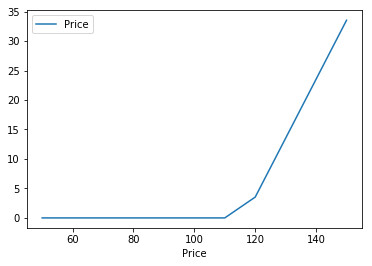

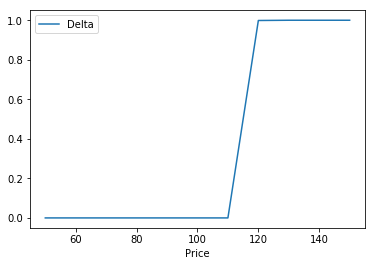

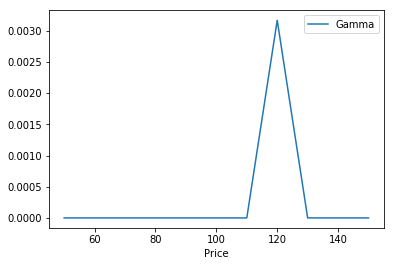

Can be adjusted with the Block 2 option


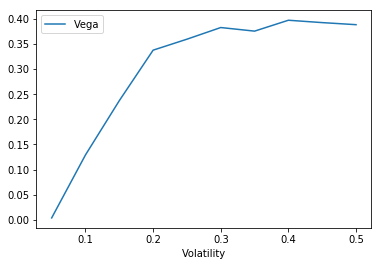

Can be adjusted with the Block 3 option


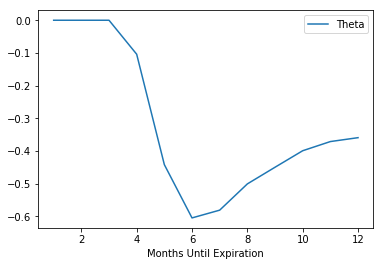

In [8]:
price_list = sorted(d.price_dict.items())
delta_list = sorted(d.delta_dict.items())
gamma_list = sorted(g.gamma_dict.items())
vega_list = sorted(v.vega_dict.items())
theta_list = sorted(t.theta_dict.items())

price_x, price_y = zip(*price_list)
delta_x, delta_y = zip(*delta_list) 
gamma_x, gamma_y = zip(*gamma_list) 
vega_x, vega_y = zip(*vega_list) 
theta_x, theta_y = zip(*theta_list) 

print('Can be adjusted with the Block 1 option')
plt.xlabel("Price")
plt.plot(price_x, price_y, label="Price")
plt.legend()
plt.show()

plt.xlabel("Price")
plt.plot(delta_x, delta_y, label="Delta")
plt.legend()
plt.show()

plt.xlabel("Price")
plt.plot(gamma_x, gamma_y, label="Gamma")
plt.legend()
plt.show()

print('Can be adjusted with the Block 2 option')
plt.xlabel("Volatility")
plt.plot(vega_x, vega_y, label="Vega")
plt.legend()
plt.show()

print('Can be adjusted with the Block 3 option')
plt.xlabel("Months Until Expiration")
plt.plot(theta_x, theta_y, label="Theta")
plt.legend()
plt.show()

In [9]:
# We can also calculate theta for ITM and ATM calls
option_t_itm = Option(option_type='Call', price=130, strike=120, sigma=0.5, interest=0.03, expiry=1, steps=200)
t_itm= Theta(time_min=12, time_max=1, increment=-1, option=option_t_itm)
t_itm.calculate(tol=0.1)

option_t_atm = Option(option_type='Call', price=120, strike=120, sigma=0.5, interest=0.03, expiry=1, steps=200)
t_atm= Theta(time_min=12, time_max=1, increment=-1, option=option_t_atm)
t_atm.calculate(tol=0.1)

Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call option at 130 with 120 strike
Finding price of a Call opti

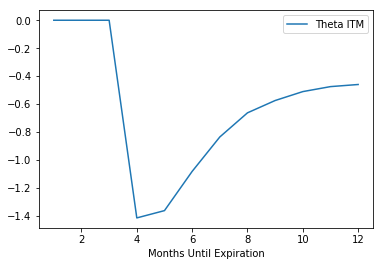

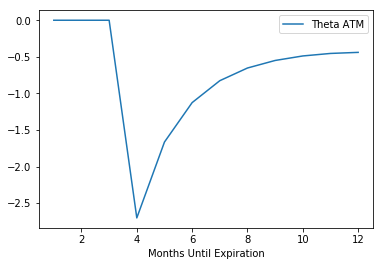

In [10]:
theta_itm_list = sorted(t_itm.theta_dict.items())
theta_atm_list = sorted(t_atm.theta_dict.items())

theta_x_itm, theta_y_itm = zip(*theta_itm_list) 
theta_x_atm, theta_y_atm = zip(*theta_atm_list) 
plt.xlabel("Months Until Expiration")
plt.plot(theta_x_itm, theta_y_itm, label="Theta ITM")
plt.legend()
plt.show()

plt.xlabel("Months Until Expiration")
plt.plot(theta_x_atm, theta_y_atm, label="Theta ATM")
plt.legend()
plt.show()